In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mousai as ms
matplotlib.rcParams['figure.figsize']=(11,5)

In [2]:
def nls_ms(x,params):
    t = params['cur_time']
    nu1 = params['nu1']
    nu2 = params['nu2']
    k = params['k']
    alpha1 = params['alpha1']
    alpha3 = params['alpha3']
    xd = np.array([[x[1]],
                   [-x[0]-nu1*x[0]**3-k*(x[0]-x[2])-nu2*(x[0]-x[2])**3],
                   [x[3]],
                   [-(1-alpha1)*x[2]-nu1*(1+alpha3)*x[2]**3
                    -k*(x[2]-x[0])-nu2*(x[2]-x[0])**3]])
    return xd
#x[1]=x1dd, x[0]=x1, x[2]=x2, x[3]=x2dd
#Equations that are being used
#x1dd+x1+nu1*x1^3+k(x1-x2)+nu2(x1-x2)^2=0
#x2dd+(1+alpha1)x2+nu1(1+alpha3)x2^3+k(x2-x1)+nu2(x2-x1)^3=0

In [39]:
#Initial Conditions-> x1(0)=X1, x1d(0)=0, x2(0)=X2, x2d(0)=0
a = np.array([[1],[0],[.1],[0]])
#Running Mousai
t,x,e,amps,phases = ms.hb_time(nls_ms,x0=a, num_harmonics=2, num_variables=4, eqform='first_order', params={'nu1':1,'nu2':0.05,'k':0.05,'alpha1':1,'alpha3':1})
#ms.hb_time(vib_thry=function to be called, x0=initial conditions array,num_harmonics>=2, 
            #num_variables= number of variables that are in xd that are not parameters, eqform= since xd is in
            #state space form this will be solved as a first order equation, params= the dictionary of parameters
            #for all of the constant variables)
amps


array([  0.00000000e+00,   2.29588740e-42,   1.77141675e-06,
         2.11618819e-10])

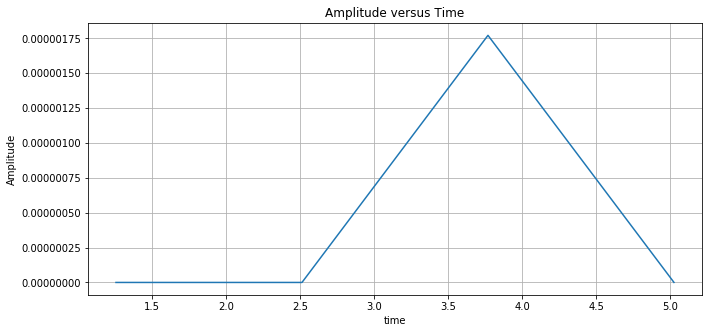

In [40]:
plt.plot(t[1:5],amps)
plt.title('Amplitude versus Time')
plt.ylabel('Amplitude')
plt.xlabel('time')
plt.grid()